# Use a genetic algorithm to find the best inputs to detect_clearsky

Optimize the inputs to `detect_clearsky` based on an automatically-generated training dataset of days classified as clearsky or cloudy.

## Load data
Read in data from a PV system in the CSI dataset.

In [1]:
csv_file = 'PGE-CSI-00242.csv'
datetime_column = 'DateTime'
datetime_format = '%d%b%y:%H:%M:%S'
power_column = 'Power'
start_date, end_date = '2010-01-01', '2012-12-31'

azimuth = 180
tilt = 0
latlon = [37.84, -122.13]

import pandas as pd
data = pd.read_csv(csv_file,usecols=[datetime_column,power_column])
data.loc[:,datetime_column] = pd.to_datetime(data[datetime_column],format=datetime_format)
data = data.set_index(datetime_column).tz_localize('Etc/GMT+8')
data = data[(data.index>=start_date)&(data.index<=end_date)]
data = data.resample('15T').interpolate()

# scale the power output to make it look like irradiance, which might help detect_clearsky converge
power = data[power_column] / data[power_column].quantile(0.95) * 1000

## Determine which days are mostly clearsky
This will serve as the training dataset with which the `detect_clearsky` inputs are optimized. For fixed PV systems, on clearsky days, the power output curve's slope will cross 0 just once (around noon). Therefore, the daily sum of the absolute value of the changes in power output will be twice the daily maximum power output.

The function `remove_cloudy_days_from_curve` in the `filtering` module implements this by labelling days that meet this criteria closely enough "clearsky". The label for the days is stored in the `day_is_clear` series.

DateTime
2010-07-02 00:00:00-08:00    0.499494
2010-07-03 00:00:00-08:00    0.241762
2010-07-04 00:00:00-08:00    0.499078
2010-07-05 00:00:00-08:00    0.497705
2010-07-06 00:00:00-08:00    0.499380
2010-07-07 00:00:00-08:00    0.499352
2010-07-08 00:00:00-08:00    0.346831
2010-07-09 00:00:00-08:00    0.499622
2010-07-10 00:00:00-08:00    0.499487
2010-07-11 00:00:00-08:00    0.497276
2010-07-12 00:00:00-08:00    0.499491
2010-07-13 00:00:00-08:00    0.499358
2010-07-14 00:00:00-08:00    0.494028
2010-07-15 00:00:00-08:00    0.496756
2010-07-16 00:00:00-08:00    0.496680
2010-07-17 00:00:00-08:00    0.498061
2010-07-18 00:00:00-08:00    0.496964
2010-07-19 00:00:00-08:00    0.498505
2010-07-20 00:00:00-08:00    0.499385
2010-07-21 00:00:00-08:00    0.479476
2010-07-22 00:00:00-08:00    0.496697
2010-07-23 00:00:00-08:00    0.499234
2010-07-24 00:00:00-08:00    0.499473
2010-07-25 00:00:00-08:00    0.488491
2010-07-26 00:00:00-08:00    0.395825
2010-07-27 00:00:00-08:00    0.499488
201

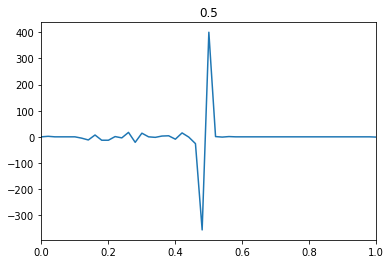

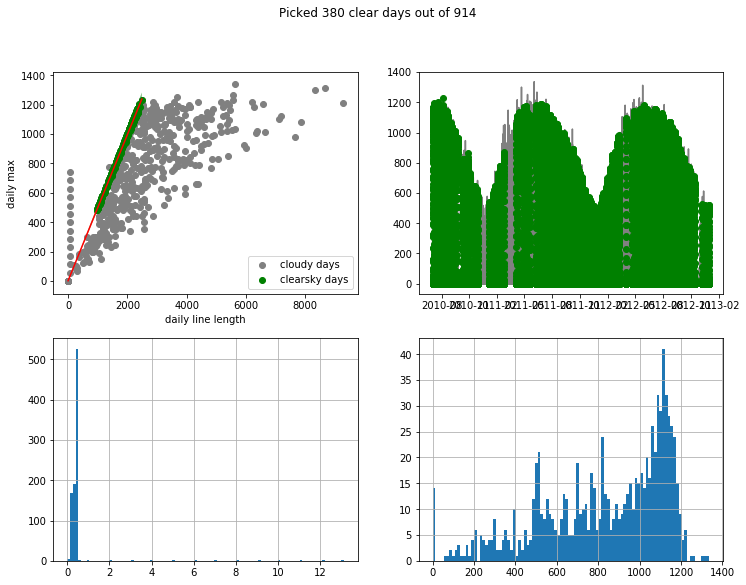

In [2]:
%matplotlib inline

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)

from filtering import remove_cloudy_days_from_curve, remove_cloudy_days
clear_irrad,is_clear = remove_cloudy_days_from_curve(data.copy(),power,viz=True,quant=None,return_when_clear=True)
day_is_clear = is_clear.copy().resample('1D').first()

## Use PVLib to simulate the clearsky POA irradiance
This is done with the `get_clearsky_irrad` and `get_clearsky_poa` functions in the `filtering` module.

In [3]:
import pvlib

pvsys = pvlib.pvsystem.PVSystem(surface_tilt=tilt,surface_azimuth=azimuth)
loc = pvlib.location.Location(latlon[0],latlon[1])
system_loc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=pvsys,location=loc)
system_loc.surface_azimuth=azimuth
system_loc.surface_tilt=tilt

# get the clearksy irradiance and poa, which will be used by the optimizer
from filtering import get_clearsky_irrad, get_clearsky_poa
clearsky = get_clearsky_irrad(system_loc, power.index, correct_bin_labelling=False)
clearsky = pd.DataFrame(clearsky)
clearsky.index=power.index.tz_convert('utc')
clearsky_poa = get_clearsky_poa(system_loc, clearsky)

C:\Users\druth\Anaconda2\lib\site-packages\pvlib\atmosphere.py:215: RuntimeWarning: invalid value encountered in power
  0.50572*(((6.07995 + (90 - z)) ** - 1.6364))))
C:\Users\druth\Anaconda2\lib\site-packages\pvlib\clearsky.py:126: RuntimeWarning: invalid value encountered in fmax
  ghi = cg1 * dni_extra * cos_zenith * tl / tl * np.fmax(ghi, 0)
C:\Users\druth\Anaconda2\lib\site-packages\pvlib\clearsky.py:131: RuntimeWarning: invalid value encountered in fmax
  bnci = dni_extra * np.fmax(bnci, 0)


## Define the acceptable ranges for the detect_clearsky inputs
The inputs will be optimized with a genetic algorithm implemented in the `evolve` module available [here](https://github.com/danjruth/evolve). The class `member_rules` defines the upper and lower limits between which to optimize the parameters, which are defined in `rules_dict`.

In [4]:
import os, sys
lib_path = os.path.abspath(os.path.join('..', '..','evolve'))
sys.path.append(lib_path)

import evolve.algorithm as ga # https://github.com/danjruth/evolve

# define the limits the different parameters can take
rules_dict = {'mean_diff':{'min':5,'max':200},
              'max_diff':{'min':5,'max':200},
              'lower_line_length':{'min':-250,'max':-1},
              'upper_line_length':{'min':1,'max':250},
              'slope_dev':{'min':0,'max':800},
              'var_diff':{'min':0,'max':1000}}
my_rules = ga.member_rules(rules_dict)

## Define the function to optimize with the genetic algorithm
The genetic algorithm finds the best variable `genes` which maximizes the output of the function `fun_to_opt`, defined below. In `fun_to_opt`, `detect_clearsky` is called with the inputs defined in the input `genes`, which is a dict. After running `detect_clearsky`, which classifies the instantaneous points as clear or cloudy, this output is reduced to the classification of days as clear or cloudy via the `remove_cloudy_days` function. Here, days for which at least 90% of the points between 9 am and 4 pm were labeled "clear" by `detect_clearsky` are classified as clear days.

Once `detect_clearsky`'s instantaneous outupt has been converted to a daily classification, it can be compared against the "training" dataset constructed at the beginning of this notebook. The metric for how well `detect_clearsky` performs is the portion of known (with the training dataset as the "known" truth) clearsky days correctly identified as such by `detect_clearsky` multiplied by the portion of known cloudy days correctly identified as such. This product is stored in `metric`, which is the output of `fun_to_opt` and thus the value that is maximized by the genetic algorithm.

This metric is at its maximum of 1 when all of the "clear" training days are determined to be clear by `detect_clearsky` and all of the "cloudy" training days are determined to be cloudy by `detect_clearsky`. When this is the case, the inputs to `detect_clearsky` have been optimized, and hopefully will classify instantaneous times correctly.

In [5]:
dur = 45 # three times the period (which is 15 minutes)
def fun_to_opt(genes):
    
    mean_diff = genes['mean_diff']
    max_diff = genes['max_diff']
    lower_line_length = genes['lower_line_length']
    upper_line_length = genes['upper_line_length']
    slope_dev = genes['slope_dev']
    var_diff = genes['var_diff']
    
    print(genes)

    dcs_isclear = pvlib.clearsky.detect_clearsky(power.copy(),clearsky_poa.copy(),power.copy().index,dur,mean_diff=mean_diff,max_diff=max_diff,lower_line_length=lower_line_length,upper_line_length=upper_line_length,var_diff=var_diff,slope_dev=slope_dev)

    foo,dcs_dayisclear = remove_cloudy_days(power.copy(),dcs_isclear,return_clear_days=True,thresh=0.90,start_time='9:00',end_time='16:00')
    
    compare_df = pd.DataFrame(index=day_is_clear.index)
    compare_df['target'] = day_is_clear
    compare_df['pred'] = dcs_dayisclear
    compare_df = compare_df.fillna(False)
        
    should_be_true = compare_df[compare_df['target']==True]
    should_be_false = compare_df[compare_df['target']==False]
    
    correct_positive_portion = float(len(should_be_true[should_be_true['pred']==True])) / float(len(should_be_true))
    correct_negative_portion = float(len(should_be_false[should_be_false['pred']==False])) / float(len(should_be_false))
    
    metric = correct_positive_portion * correct_negative_portion
    print(str(correct_positive_portion)+' positive and '+str(correct_negative_portion)+' negative with this configuration.')
    
    return metric

## Run the algorithm

First create an initial popultation `my_pop` of 20 sets of inputs to `detect_clearsky`. Then create an instance `alg` of the algorithm, which will go through 4 generations. When it is run with the `run` method, the optimal result (the best `detect_clearsky`) inputs will be stored in `g`. It'll also make a plot of all the configurations that have been evaluated, coloring each point by the output it yields.

{'mean_diff': 68.5291771692177, 'var_diff': 655.295291711988, 'lower_line_length': -176.88386422925305, 'slope_dev': 558.0711730715396, 'max_diff': 113.94948025019418, 'upper_line_length': 203.83831500814705}
0.471052631579 positive and 0.919475655431 negative with this configuration.
{'mean_diff': 162.61447123040608, 'var_diff': 352.7322166174439, 'lower_line_length': -64.14441752255101, 'slope_dev': 750.0831000985081, 'max_diff': 16.29790239792306, 'upper_line_length': 209.06131186827574}
0.0 positive and 1.0 negative with this configuration.
{'mean_diff': 156.6216101687257, 'var_diff': 835.541589196739, 'lower_line_length': -243.0111060479165, 'slope_dev': 141.70450543653698, 'max_diff': 83.86697988998064, 'upper_line_length': 230.16364997788781}
0.0184210526316 positive and 0.975655430712 negative with this configuration.
{'mean_diff': 128.67891093123427, 'var_diff': 778.2248902598807, 'lower_line_length': -177.28203006656977, 'slope_dev': 770.3709758006186, 'max_diff': 177.4280116

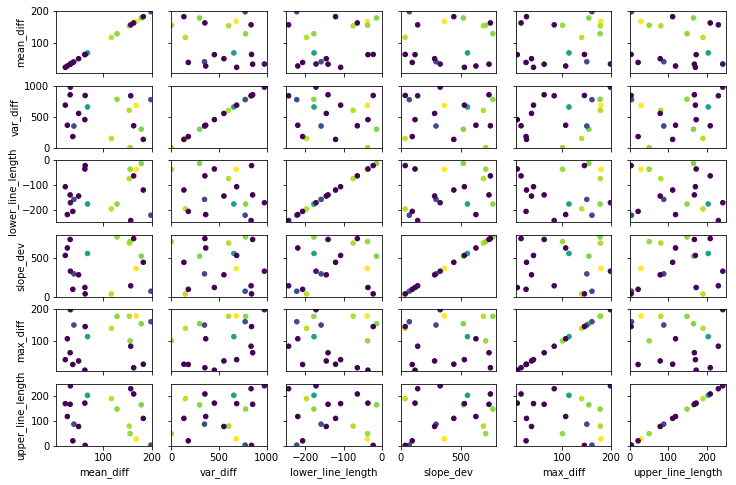

Reinitializing...
Mutation and crossover...
Back to the list of members...
TOP SCORE:
lower_line_length    -38.1965
max_diff              179.077
mean_diff             167.627
slope_dev             364.848
upper_line_length     28.7925
var_diff              680.191
score                0.768007
has_changed                 0
Name: 0, dtype: object
{'mean_diff': 167.62717520522904, 'var_diff': 680.19108575849771, 'lower_line_length': -38.196453640662753, 'slope_dev': 364.84786652205344, 'max_diff': 179.07735032181665, 'upper_line_length': 28.792459938949815}
0.876315789474 positive and 0.876404494382 negative with this configuration.
{'mean_diff': 117.17487427777861, 'var_diff': 297.36342721872967, 'lower_line_length': -196.54720255724129, 'slope_dev': 71.05405937950286, 'max_diff': 135.23800721538092, 'upper_line_length': 190.2356303326354}
0.8 positive and 0.825842696629 negative with this configuration.
{'mean_diff': 149.93303565694271, 'var_diff': 600.52178345096718, 'lower_line_leng

In [7]:
%matplotlib inline

# setup and run the genetic algorithm
my_pop = ga.population(my_rules,pop_size=20)
alg = ga.genetic_algorithm(fun_to_opt,max_iters=4)
g = alg.run(my_pop);

## Run detect_clearsky with these optimal inputs
After it's run, create a plot of the power output, showing which points are determined to be clearsky. The background of the plot gives the day's classification in the training dataset.

<IPython.core.display.Javascript object>


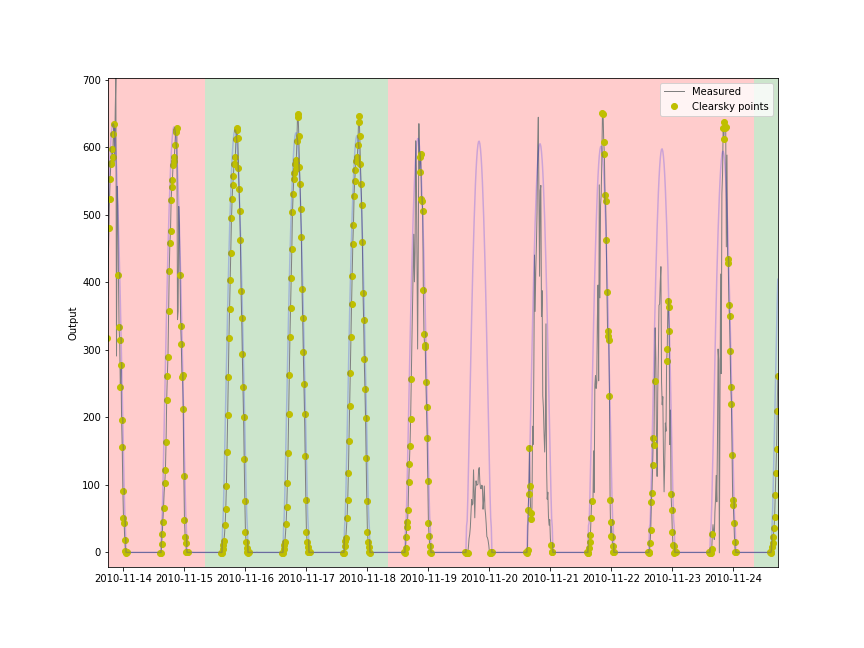

In [12]:
# use the best set of detect_clearsky inputs to see when it's cloudy
final_isclear, components, alpha = pvlib.clearsky.detect_clearsky(power.copy().values,clearsky_poa.copy(),power.copy().index,dur,mean_diff=g['mean_diff'],max_diff=g['max_diff'],lower_line_length=g['lower_line_length'],upper_line_length=g['upper_line_length'],var_diff=g['var_diff'],slope_dev=g['slope_dev'],return_components=True)

# plot the results
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.plot(power,lw=1,color='gray',label='Measured')
ax1.plot(power[final_isclear==True],'o',color='y',label='Clearsky points')
ax1.legend()
ax1.set_ylabel('Output')
#ax2=ax1.twinx()
ax1.plot(clearsky_poa*alpha,color='b',alpha=0.2)

c_dict = {True:'g',False:'r'}
[ax1.axvspan(day_is_clear.index[di],day_is_clear.index[di+1],facecolor=c_dict[day_is_clear.iloc[di]],alpha=0.2) for di in range(len(day_is_clear.index)-1)]

plt.show()